<a href="https://colab.research.google.com/github/nandhukumar86/CapstonePneumoniaDetection/blob/main/PneumoniaDetectionModel_DenseNet_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline
import cv2
import skimage.io as io
import os
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import Conv2D, Concatenate, Reshape, UpSampling2D
import pickle
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.losses import binary_crossentropy
import gc
from tensorflow.keras.applications import DenseNet121, DenseNet201
from tensorflow.keras.applications import VGG16
from google.colab.patches import cv2_imshow
from tensorflow import reduce_sum
from tensorflow.keras.backend import log,epsilon
 
from sklearn.model_selection import train_test_split
from keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy


In [2]:
file = open('/content/drive/MyDrive/CapstoneDataSet/dataset/RezisedLabel-1.pickle', 'rb')
dfData = pickle.load(file)
file.close()

In [3]:
# dfData_0 = dfData[dfData['Target'] == 0].sample(9555)
# dfData_1 = dfData[dfData['Target'] == 1].sample(9555)
 
# dfData = pd.concat([dfData_0, dfData_1], axis=0, ignore_index=True)
 
dfData = dfData.sample(frac=1)

In [4]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1])
  union = K.sum(y_true, axis=[1]) + K.sum(y_pred, axis=[1])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def loss(y_true, y_pred):
    # return categorical_crossentropy(y_true, y_pred) - log(dice_coef(y_true, y_pred) + epsilon())
    return 1 - (dice_coef(y_true, y_pred) + epsilon())

In [5]:
X = []
y_classify = []
y_segment = []
 
i = 0
for pId in dfData['patientId'].unique():
  data = dfData[dfData['patientId'] == pId][['Image256','xo','yo','widtho','heighto','Target']]
  pData = cv2.cvtColor(cv2.resize(data.iloc[0][0],(256,256)), cv2.COLOR_BAYER_GR2RGB)
  X.append(pData)
  mask = np.zeros((256,256))
  if (data.iloc[0][5] == 1):
    j = 0
    for segment in range(data.shape[0]):
      xo = int(data.iloc[j][1])
      yo = int(data.iloc[j][2])
      wo = int(data.iloc[j][1] + data.iloc[j][3])
      ho = int(data.iloc[j][2] + data.iloc[j][4])
      mask = cv2.rectangle(mask,(xo, yo),(wo, ho),(255,0,0),-1)
      j = j+1
  y_classify.append(data.iloc[0][5])
  fmask = cv2.resize(mask,(64,64), interpolation=cv2.INTER_NEAREST)
  y_segment.append(fmask)
  if (i%5000 == 0):
    print(i, " completed")
  i = i + 1

0  completed
5000  completed
10000  completed
15000  completed
20000  completed
25000  completed


In [6]:
X_train, X_val, y_train_classify, y_val_classify, y_train_segment, y_val_segment = \
train_test_split(X, y_classify, y_segment, test_size=0.30, random_state=100)

In [7]:
tensorflow.keras.backend.clear_session()

In [8]:
iLayer = tensorflow.keras.Input(shape=(256,256,3), name='customInputLayer')
x = tensorflow.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)(iLayer)
oLayer = DenseNet121(include_top=False,weights='imagenet', input_tensor=x,input_shape=(256,256,3))
 
model = Model(iLayer,oLayer.output)
 
pcTrainableLayers = 0.9
 
lengthLayers = len(model.layers)
pcLayers = int(pcTrainableLayers * lengthLayers)
for i in range(pcLayers):
  model.layers[i].trainable = False

In [9]:
layer8x8 = model.get_layer('conv5_block16_2_conv').output
layer16x16 = model.get_layer('conv4_block24_2_conv').output
layer32x32 = model.get_layer('conv3_block12_2_conv').output
layer64x64 = model.get_layer('conv2_block6_2_conv').output
layer128x128 = model.get_layer('conv1/conv').output
 
output_segment = Concatenate()([UpSampling2D()(layer8x8), layer16x16])
output_segment = Concatenate()([UpSampling2D()(output_segment), layer32x32])
output_segment = Concatenate()([UpSampling2D()(output_segment), layer64x64])
output_segment = Concatenate()([UpSampling2D()(output_segment), layer128x128])
output_segment = UpSampling2D()(output_segment)
output_segment = Conv2D(16, kernel_size = 1,activation='relu')(output_segment)
output_segment = Dropout(0.2)(output_segment)
output_segment = Conv2D(7, kernel_size = 1,activation='relu')(output_segment)
output_segment = MaxPooling2D()(output_segment)
output_segment = MaxPooling2D()(output_segment)
output_segment = Conv2D(1, kernel_size = 1,activation='sigmoid', name='output_segment')(output_segment)

 
 
output_classify = Concatenate()([UpSampling2D()(layer8x8), layer16x16])
output_classify = Concatenate()([UpSampling2D()(output_classify), layer32x32])
output_classify = Concatenate()([UpSampling2D()(output_classify), layer64x64])
output_classify = Flatten()(output_classify)
output_classify = Dropout(0.2)(output_classify)
output_classify = Dense(2, activation='softmax', name='output_classify')(output_classify)
 
model = Model(model.input, [output_classify, output_segment])

In [10]:
# X_train = preprocess_input(np.array(X_train))
# X_val = preprocess_input(np.array(X_val))
 
X_train = np.array(X_train)
X_val = np.array(X_val)
 
y_train_classify = np.array(y_train_classify)
y_val_classify = np.array(y_val_classify)
 
y_train_classify = np.array([y_train_classify, ~y_train_classify+2]).T
y_val_classify = np.array([y_val_classify, ~y_val_classify+2]).T
 
y_train_segment = np.array(y_train_segment)
y_val_segment = np.array(y_val_segment)

In [11]:
print('Train Data: ',X_train.shape, y_train_classify.shape, y_train_segment.shape)
print('Validation Data: ',X_val.shape, y_val_classify.shape, y_val_segment.shape)

Train Data:  (18678, 256, 256, 3) (18678, 2) (18678, 64, 64)
Validation Data:  (8006, 256, 256, 3) (8006, 2) (8006, 64, 64)


In [12]:
losses = {
    "output_segment" : categorical_crossentropy,
    "output_classify" : categorical_crossentropy
}
 
metrics = {
    "output_segment" : dice_coef,
    "output_classify" : "accuracy"
}
 
model.compile(loss = losses, optimizer='adam', metrics = metrics)
 
hist = model.fit(
    x = X_train, 
    y = {"output_classify": y_train_classify, "output_segment": y_train_segment}, 
    epochs=50, 
    batch_size=16, 
    validation_data=(X_val, {"output_classify": y_val_classify, "output_segment" : y_val_segment }), 
    verbose=1)

Epoch 1/50
1168/1168 [==============================] - 152s 121ms/step - loss: 1667.0693 - output_classify_loss: 3.8988 - output_segment_loss: 1663.1719 - output_classify_accuracy: 0.7615 - output_segment_dice_coef: 0.2686 - val_loss: 1658.4517 - val_output_classify_loss: 3.4094 - val_output_segment_loss: 1655.0427 - val_output_classify_accuracy: 0.7617 - val_output_segment_dice_coef: 0.2550
Epoch 2/50
1168/1168 [==============================] - 138s 118ms/step - loss: 1637.4708 - output_classify_loss: 3.2170 - output_segment_loss: 1634.2552 - output_classify_accuracy: 0.7989 - output_segment_dice_coef: 0.3495 - val_loss: 1647.3083 - val_output_classify_loss: 3.1372 - val_output_segment_loss: 1644.1710 - val_output_classify_accuracy: 0.8118 - val_output_segment_dice_coef: 0.3224
Epoch 3/50
1168/1168 [==============================] - 138s 118ms/step - loss: 1625.3350 - output_classify_loss: 2.5911 - output_segment_loss: 1622.7466 - output_classify_accuracy: 0.8250 - output_segment_di

In [13]:
classify_result, segment_result = model.predict(X_train)

1


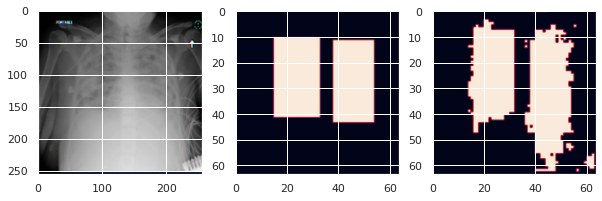

In [52]:
n = int(np.random.rand(1)[0]*X_train.shape[0])
 
fig, axes = plt.subplots(1,3,figsize=(10,10))
axes[0].imshow(X_train[n])
t_image = y_train_segment[n].astype('int')
axes[1].imshow(t_image);
r_image= (segment_result[n].reshape(64,64).round()).astype('int')
axes[2].imshow(r_image)
 
print(~classify_result[n].argmax()+2)

0


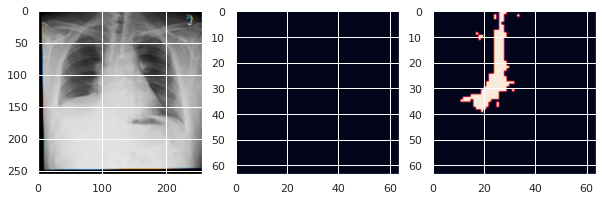

In [53]:
n = int(np.random.rand(1)[0]*X_train.shape[0])
 
fig, axes = plt.subplots(1,3,figsize=(10,10))
axes[0].imshow(X_train[n])
t_image = y_train_segment[n].astype('int')
axes[1].imshow(t_image);
r_image= (segment_result[n].reshape(64,64).round()).astype('int')
axes[2].imshow(r_image)
 
print(~classify_result[n].argmax()+2)

1


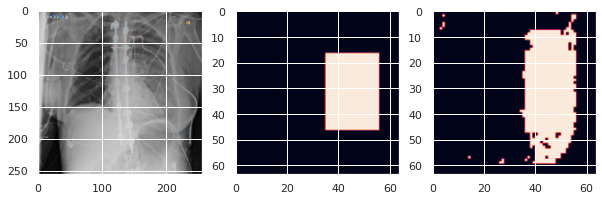

In [57]:
n = int(np.random.rand(1)[0]*X_train.shape[0])
 
fig, axes = plt.subplots(1,3,figsize=(10,10))
axes[0].imshow(X_train[n])
t_image = y_train_segment[n].astype('int')
axes[1].imshow(t_image);
r_image= (segment_result[n].reshape(64,64).round()).astype('int')
axes[2].imshow(r_image)
 
print(~classify_result[n].argmax()+2)

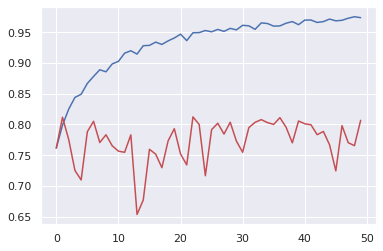

In [54]:
epochs = range(len(hist.history['output_segment_loss']))
plt.plot(epochs, hist.history['output_classify_accuracy'],'b', label = 'Accuracy')
plt.plot(epochs, hist.history['val_output_classify_accuracy'],'r', label = 'Accuracy')

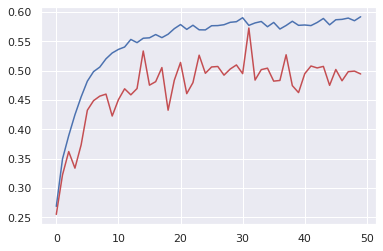

In [55]:
epochs = range(len(hist.history['output_segment_loss']))
plt.plot(epochs, hist.history['output_segment_dice_coef'],'b', label = 'Mean Squared Error')
plt.plot(epochs, hist.history['val_output_segment_dice_coef'],'r', label = 'Mean Squared Error')

In [56]:
model.save('/content/drive/MyDrive/CapstoneDataSet/modelPickle/model-dn-v1.h5')